In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score



In [14]:

file_path = '/content/drive/MyDrive/Business_Automation_Task/new_preprocessed_data.csv'
df = pd.read_csv(file_path)

X = df.drop('target', axis=1)
y = df['target']

# # Convert categorical labels to numerical values
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)



In [15]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=15)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=15)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



In [16]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [17]:
class RegularizedNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(RegularizedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.bn2 = nn.BatchNorm1d(output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        # x = self.bn1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        # x = self.bn2(x)
        x = self.softmax(x)
        return x



In [18]:
# Define hyperparameters
dropout_rate = 0.05
weight_decay = 1e-5
learning_rate = 0.001
epochs = 500

input_size = X_train.shape[1]
hidden_size = 64
output_size = 4
batch_size = 32

train_losses = []
val_losses = []




In [19]:
# Create the model, loss function, and optimizer
model = RegularizedNN(input_size, hidden_size, output_size, dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Create DataLoader for training, validation, and test sets
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)



In [20]:
# Training loop
for epoch in range(epochs):
    model.train()
    t_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        t_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = correct_train / total_train

    train_losses.append(t_loss / len(train_loader))

    # Validation loop
    model.eval()
    v_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, labels)
            v_loss += val_loss.item()

            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_accuracy = correct_val / total_val

    val_losses.append(v_loss / len(val_loader))

    print(f'Epoch {epoch + 1}/{epochs}, T_Accuracy: {train_accuracy * 100:.2f}%, V_Accuracy: {val_accuracy * 100:.2f},\
     T_loss: {t_loss / len(train_loader):.4f}, V_loss: {v_loss / len(val_loader):.4f}')

    # Learning rate scheduling
    scheduler.step()

Epoch 1/500, T_Accuracy: 10.88%, V_Accuracy: 26.03,     T_loss: 1.4065, V_loss: 1.3931
Epoch 2/500, T_Accuracy: 29.41%, V_Accuracy: 42.47,     T_loss: 1.3713, V_loss: 1.3655
Epoch 3/500, T_Accuracy: 46.18%, V_Accuracy: 49.32,     T_loss: 1.3390, V_loss: 1.3382
Epoch 4/500, T_Accuracy: 57.06%, V_Accuracy: 56.16,     T_loss: 1.3059, V_loss: 1.3129
Epoch 5/500, T_Accuracy: 59.12%, V_Accuracy: 56.16,     T_loss: 1.2768, V_loss: 1.2874
Epoch 6/500, T_Accuracy: 59.41%, V_Accuracy: 56.16,     T_loss: 1.2485, V_loss: 1.2652
Epoch 7/500, T_Accuracy: 60.59%, V_Accuracy: 56.16,     T_loss: 1.2225, V_loss: 1.2460
Epoch 8/500, T_Accuracy: 61.47%, V_Accuracy: 54.79,     T_loss: 1.2007, V_loss: 1.2266
Epoch 9/500, T_Accuracy: 64.12%, V_Accuracy: 58.90,     T_loss: 1.1783, V_loss: 1.2115
Epoch 10/500, T_Accuracy: 64.71%, V_Accuracy: 61.64,     T_loss: 1.1623, V_loss: 1.1950
Epoch 11/500, T_Accuracy: 65.88%, V_Accuracy: 63.01,     T_loss: 1.1465, V_loss: 1.1825
Epoch 12/500, T_Accuracy: 68.53%, V_Accur

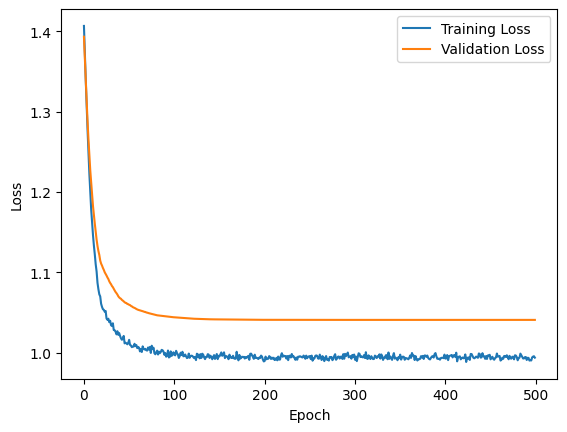

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Accuracy: 75.34%
Precision: 0.7593, Recall: 0.7534, F1-Score: 0.7529


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


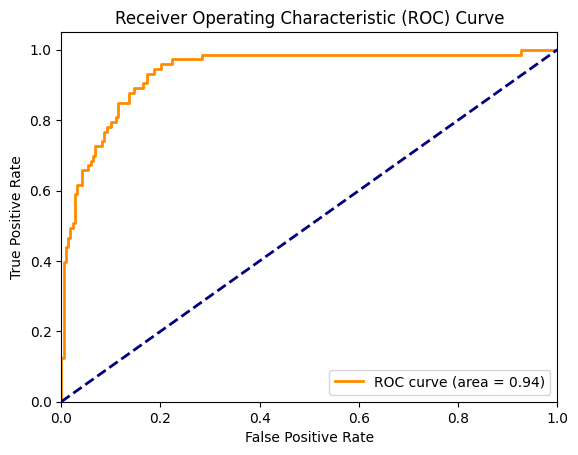

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import numpy as np

model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    all_predicted = []
    all_labels = []

    for inputs, labels in test_loader:
        test_outputs = model(inputs)

        _, predicted = torch.max(test_outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect predictions and true labels for later use
        all_predicted.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_predicted, average='weighted')
    recall = recall_score(all_labels, all_predicted, average='weighted')
    f1 = f1_score(all_labels, all_predicted, average='weighted')

    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    # Calculate AUC-ROC curve
    one_hot_labels = np.eye(output_size)[all_labels]
    fpr, tpr, _ = roc_curve(one_hot_labels.ravel(), model(torch.tensor(X_test, dtype=torch.float32)).numpy().ravel())
    auc_score = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()